## 反向传播

- [https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/readings/L06%20Backpropagation.pdf](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/readings/L06%20Backpropagation.pdf)

- [Automatic differentiation in machine learning: a survey](https://arxiv.org/abs/1502.05767)

在深度学习中我们通常用反向传播来更新网络参数。我们假定一个模型，具有单个变量的输入，只有一个训练样本$(x, t)$。网络模型是一个线性模型，带有一个非线形的`sigmoid`层，然后用均方差作为其`Loss`函数，这个模型用公式可以表示为如下形式：

$$
z = wx + b \\
y = \sigma(z) \\
\mathcal{L} = \frac{1}{2}(y - t)^{2}
$$

再考虑添加一个正则化$\frac{\lambda}{2} w^{2}$，期望模型变得更加简单一点，也就是期望$w$变成`0`。此时损失函数将会变为:

$$
\mathcal{R} = \frac{1}{2} w^{2} \\
\mathcal{L}_{reg} = \mathcal{L} + \lambda \mathcal{R}
$$

其中$\lambda$是超参数。

想要做梯度下降的话，我们就需要对$w$和$b$求偏微分：$\partial \mathcal{E} / \partial w$和$\partial \mathcal{E} / \partial b$。

将目标函数展开可以表示为:

$$
\mathcal{L}_{\mathrm{reg}}=\frac{1}{2}(\sigma(w x+b)-t)^{2}+\frac{\lambda}{2} w^{2}
$$

对$w$求偏导数可以得到:

$$
\begin{aligned}
\frac{\partial \mathcal{L}_{\mathrm{reg}}}{\partial w} &=\frac{\partial}{\partial w}\left[\frac{1}{2}(\sigma(w x+b)-t)^{2}+\frac{\lambda}{2} w^{2}\right] \\
&=\frac{1}{2} \frac{\partial}{\partial w}(\sigma(w x+b)-t)^{2}+\frac{\lambda}{2} \frac{\partial}{\partial w} w^{2} \\
&=(\sigma(w x+b)-t) \frac{\partial}{\partial w}(\sigma(w x+b)-t)+\lambda w \\
&=(\sigma(w x+b)-t) \sigma^{\prime}(w x+b) \frac{\partial}{\partial w}(w x+b)+\lambda w \\
&=(\sigma(w x+b)-t) \sigma^{\prime}(w x+b) x+\lambda w
\end{aligned}
$$

对$b$求偏导数可以得到:

$$
\begin{aligned}
\frac{\partial \mathcal{L}_{\mathrm{reg}}}{\partial b} &=\frac{\partial}{\partial b}\left[\frac{1}{2}(\sigma(w x+b)-t)^{2}+\frac{\lambda}{2} w^{2}\right] \\
&=\frac{1}{2} \frac{\partial}{\partial b}(\sigma(w x+b)-t)^{2}+\frac{\lambda}{2} \frac{\partial}{\partial b} w^{2} \\
&=(\sigma(w x+b)-t) \frac{\partial}{\partial b}(\sigma(w x+b)-t)+0 \\
&=(\sigma(w x+b)-t) \sigma^{\prime}(w x+b) \frac{\partial}{\partial b}(w x+b) \\
&=(\sigma(w x+b)-t) \sigma^{\prime}(w x+b)
\end{aligned}
$$

上述方法确实能够得出正确的解，但是有以下缺陷:

1. 计算非常冗余复杂；
2. 上述计算过程中有很多地方是重复计算的，比如$wx+b$计算了四次, $(\sigma(w x+b)-t) \sigma^{\prime}(w x+b)$计算了两次。

### 多变量链式求导：简单的例子



其实上述方法就是在计算一元链式求导多次，一元链式求导可以定义为如下形式:

$$
\frac{\mathrm{d}}{\mathrm{d} t} f(g(t))=f^{\prime}(g(t)) g^{\prime}(t)
$$

多变量的求导可以定义为:

$$
\frac{\mathrm{d}}{\mathrm{d} t} f(x(t), y(t))=\frac{\partial f}{\partial x} \frac{\mathrm{d} x}{\mathrm{~d} t}+\frac{\partial f}{\partial y} \frac{\mathrm{d} y}{\mathrm{~d} t}
$$

为了方便叙述，定义一个符号，比如对$v$的导数可以定义为：

$$
\bar{v} \triangleq \frac{\partial \mathcal{L}}{\partial v}
$$

那么上述$\frac{\mathrm{d}}{\mathrm{d} t} f(x(t), y(t))=\frac{\partial f}{\partial x} \frac{\mathrm{d} x}{\mathrm{~d} t}+\frac{\partial f}{\partial y} \frac{\mathrm{d} y}{\mathrm{~d} t}$可以表示为:

$$
\bar{t} = \bar{x} \frac{dx}{dt} + \bar{y} \frac{dy}{dt}
$$

这样我们就可以用偏微分的计算方法来计算$\frac{dx}{dt}$, 而$\bar{x}$和$\bar{y}$是之前就已经计算好的。

### 多变量求导：计算图模式

上述带有正则化的模型用计算图可以表示为:

<img src="../images/06-jisuantu.png" width="40%">

整个模型可以表示为:

$$
z = wx + b \\
y = \sigma(z) \\
\mathcal{L} = \frac{1}{2}(y - t)^{2} \\
\mathcal{R} = \frac{1}{2} w^{2} \\
\mathcal{L}_{reg} = \mathcal{L} + \lambda \mathcal{R}
$$

反向传播的时候，我们需要去计算得到$\bar{w}$和$\bar{b}$， 就需要反复利用链式求导计算偏微分。

也就是要从结果(这里定义为$\mathcal{E}$)，一步一步往前去计算它的前一个节点的导数。定义$v_{1}, \cdots, v_{N}$是计算图中的所有节点，并且以输入到输出的拓扑顺序进行排序的。

我们期望去计算得到所有节点的偏导数$\bar{v}_{i}$, 神经网络工作的时候就是走一遍前向传播，然后走一遍反向传播。最末尾的这个节点是$v_{N}$, 我们也需去得到它的偏导数，为了方便计算，我们通常令其偏导数为1。也就是$\bar{v_{N}} = 1$。

此时整个算法的逻辑可以表示为:

For $i=1, \ldots, N$


$\ $    Compute $v_{i}$ as a function of $\operatorname{Pa}\left(v_{i}\right)$

$v_{N}=1$

For $i=N-1, \ldots, 1$

$\ $    $\overline{v_{i}}=\sum_{j \in \operatorname{Ch}\left(v_{i}\right)} \overline{v_{j}} \frac{\partial v_{j}}{\partial v_{i}}$

`OK`, 到此，我们就可以通过上述的这个计算公式来走反向传播了:

首先是目标函数的导数被定义为`1`，也就是$\bar{\mathcal{L}_{reg}} = 1$。

之后我们对$\mathcal{L}_{reg}$的两个父亲节点求偏导数，也就是$\bar{\mathcal{R}}$和$\bar{\mathcal{L}}$：

1. $\bar{\mathcal{R}}$的孩子节点为$\mathcal{L}_{reg}$，所以依据公式$\overline{v_{j}} \frac{\partial v_{j}}{\partial v_{i}}$, 我们可以得到$\bar{\mathcal{R}} = \bar{\mathcal{L_{reg}}} \frac{\mathcal{dL_{reg}}}{d\mathcal{R}} = \bar{\mathcal{L}_{reg}} \lambda$

2. $\bar{\mathcal{L}}$的孩子节点也为$\mathcal{L}_{reg}$, 所以$\bar{\mathcal{L}} = \bar{\mathcal{L}_{reg}} \frac{d \mathcal{L}_{reg}}{d \mathcal{L}} = \bar{\mathcal{L}_{reg}}$

我们再进行反向传播，来计算$\bar{y}$和$\bar{z}$:

1. $\bar{y} = \bar{\mathcal{L}} \frac{d \mathcal{L}}{d y} = \bar{\mathcal{L}} (y - t)$。
2. $\bar{z} = \bar{y} \frac{d y}{d z} = \bar{y} \sigma^{\prime}(z)$。

最后到了我们需要更新的参数$w$和$b$:

1. $w$有两个父亲节点$z$和$\mathcal{R}$，所以$\bar{w} = \bar{z} \frac{\partial{z}}{\partial{w}} + \bar{\mathcal{R}} \frac{d \mathcal{R}}{d w}= \bar{z} x + \bar{\mathcal{R}}w$。
2. $b$有一个父亲节点$z$，所以$\bar{b} = \bar{z} \frac{\partial{z}}{\partial{b}} = \bar{z}$。

总结一下推导过程为:

$$
\begin{aligned}
\overline{\mathcal{L}_{\text {reg }}} &=1 \\
\overline{\mathcal{R}} &=\overline{\mathcal{L}_{\text {reg }}} \frac{\mathrm{d} \mathcal{L}_{\text {reg }}}{\mathrm{d} \mathcal{R}} \\
&=\overline{\mathcal{L}_{\text {reg }}} \lambda \\
\overline{\mathcal{L}} &=\overline{\mathcal{L}_{\text {reg }}} \frac{\mathrm{d} \mathcal{L}_{\text {reg }}}{\mathrm{d} \mathcal{L}} \\
&=\overline{\mathcal{L}_{\text {reg }}} \\
\bar{y} &=\overline{\mathcal{L}} \frac{\mathrm{d} \mathcal{L}}{\mathrm{d} y} \\
&=\overline{\mathcal{L}}(y-t) \\
\bar{z} &=\bar{y} \frac{\mathrm{d} y}{\mathrm{~d} z} \\
&=\bar{y} \sigma^{\prime}(z) \\
\bar{w} &=\bar{z} \frac{\partial z}{\partial w}+\overline{\mathcal{R}} \frac{\mathrm{d} \mathcal{R}}{\mathrm{d} w} \\
&=\bar{z} x+\overline{\mathcal{R}} w \\
\bar{b} &=\bar{z} \frac{\partial z}{\partial b} \\
&=\bar{z}
\end{aligned}
$$

总结一下最终结果为:

$$
\begin{aligned}
\overline{\mathcal{L}_{\text {reg }}} &=1 \\
\overline{\mathcal{R}} &=\overline{\mathcal{L}_{\text {reg }}} \lambda \\
\overline{\mathcal{L}} &=\overline{\mathcal{L}_{\text {reg }}} \\
\bar{y} &=\overline{\mathcal{L}}(y-t) \\
\bar{z} &=\bar{y} \sigma^{\prime}(z) \\
\bar{w} &=\bar{z} x+\overline{\mathcal{R}} w \\
\bar{b} &=\bar{z}
\end{aligned}
$$

可以看到相比之前的推导偏微分方程的方式，这种反向传播的方式更为简洁。

### 反向传播实战



#### 创建数据集

为了增加难度，这里创建一个非线形可分的数据集。

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

def make_dataset(num_points):
    radius = 5
    data = []
    labels = []
    # 生成正类样本，标签为1。
    for i in range(num_points // 2):  # 循环创建多少个样本
        r = np.random.uniform(0, radius * 0.5) # 设置半径长度
        angle = np.random.uniform(0, 2 * math.pi)
        x = r * math.sin(angle)  # 第一个维度的特征
        y = r * math.cos(angle)  # 第二个维度的特征
        data.append([x, y])  # 将特征数据存起来
        labels.append(1)  # 将标签数据存起来。
    
    # 生成负样本，标签为0。
    for i in range(num_points // 2):  # 循环创建多少个样本
        r = np.random.uniform(radius * 0.7, radius)  # 设置半径长度
        angle = np.random.uniform(0, 2 * math.pi)
        x = r * math.sin(angle)  # 第一个维度的特征
        y = r * math.cos(angle)  # 第二个维度的特征
        data.append([x, y])  # 将特征数据存起来
        labels.append(0)  # 将标签数据存起来。
    
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

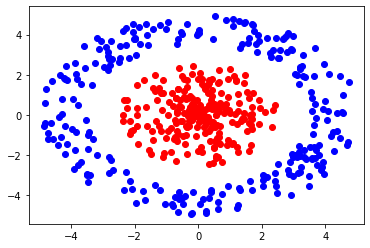

In [2]:
num_data = 500
data, labels = make_dataset(num_data)

plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red')  # 前num_data//2个样本为第一类。
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') # 后num_data//2个样本为第二类。
plt.show()

#### 构建模型

上述给定的数据集，特征维度为两个维度$\mathbf{x}=\left[x_{1}, x_{2}\right]^{T}$, 输出的概率可以表示为$\operatorname{Pr}(t=1 \mid \mathbf{x})$，其中$t$表示数据点$\mathbf{x}$的标签。

为了简单起见，这里只创建一个具有单隐藏层的神经网络。隐藏层单元数为3个。可以采用如下公式表示:

$$
\mathbf{g} = \mathbf{Ux} + b \\
\mathbf{h} = tanh{g} \\
z = \mathbf{Wh} + c \\
y = \sigma(z)
$$

在上述公式中，$\mathbf{U}=\left(\begin{array}{ll}u_{11} & u_{12} \\ u_{21} & u_{22} \\ u_{31} & u_{32}\end{array}\right) \in \mathbb{R}^{3 \times 2}, \mathbf{b}=\left(\begin{array}{l}b_{1} \\ b_{2} \\ b_{3}\end{array}\right) \in \mathbb{R}^{3}, \mathbf{W}=\left(\begin{array}{lll}w_{1} & w_{2} & w_{3}\end{array}\right) \in \mathbb{R}^{1 \times 3}, c \in \mathbb{R}$。

令$\mathbf{X}=\left(\begin{array}{cc}x_{11} & x_{12} \\ \vdots & \vdots \\ x_{N 1} & x_{N 2}\end{array}\right)$为一个矩阵，包含$N$个数据点，每一行分别表示一个数据点。然后我们可以将其向量化一下:

$$
\begin{gathered}
\mathbf{G}=\mathbf{X} \mathbf{U}^{T}+\mathbf{1 b}^{T} \\
\mathbf{H}=\tanh (\mathbf{G}) \\
\mathbf{z}=\mathbf{H} \mathbf{W}^{T}+\mathbf{1} c \\
\mathbf{y}=\sigma(\mathbf{z})
\end{gathered}
$$

如果将其写成标量形式的话，可以表示为:

$$
\begin{gathered}
g_{i j}=u_{j 1} x_{i 1}+u_{j 2} x_{i 2}+b_{j} \\
h_{i j}=\tanh \left(g_{i j}\right) \\
z_{i}=w_{1} h_{i 1}+w_{2} h_{i 2}+w_{3} h_{i 3}+c \\
y_{i}=\sigma\left(z_{i}\right)
\end{gathered}
$$

其中$i$表示数据点的索引，$j$表示隐藏层单元的索引，所以$i \in \{1, \cdots, N\}$并且$j \in \{1, 2, 3\}$。

In [3]:
# 初始化神经网络参数
params = {}
params['U'] = np.random.randn(3, 2)
params['b'] = np.zeros(3)
params['W'] = np.random.rand(3)
params['c'] = 0

from scipy.special import expit as sigmoid
def forward(X, params):
    """
    # 传入数据X和网络参数，计算前向传播。
    """
    G = np.dot(X, params['U'].T) + params['b']
    H = np.tanh(G)
    z = np.dot(H, params['W'].T) + params['c']
    y = sigmoid(z)
    return y

#### 可视化训练之前的网络预测结果

/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_10959/1646430344.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))


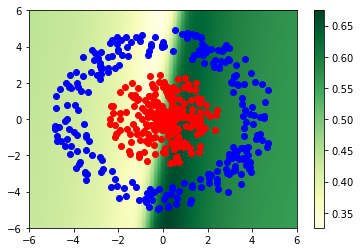

In [4]:
num_points = 200
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)

points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])  # 产生网格数据点，也就是说测试数据布满整个图
Y = forward(points, params).reshape(num_points, num_points)
X1, X2 = np.meshgrid(x1s, x2s)

plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))
plt.colorbar()
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue')
plt.show()

#### 反向传播训练网络

首先我们需要设置损失函数，交叉熵损失函数可以表示为:

$$
\mathcal{L}_{C E}(y, t)=-t \log (y)-(1-t) \log (1-y)
$$

其中$y=\operatorname{Pr}(t=1 \mid \mathbf{x})$, $t$表示真实的标签。但是这样计算偏导数$\frac{\partial L}{dy}$会数值不稳定，因此直接结合逻辑函数和交叉熵损失到一个函数中，叫做逻辑交叉熵损失函数:

$$
\mathcal{L}_{L C E}(z, t)=t \log (1+\exp (-z))+(1-t) \log (1+\exp (z))
$$

其梯度可以表示为:

$$
\begin{aligned}
\frac{\mathrm{d} \mathcal{L}_{\mathrm{LCE}}}{\mathrm{d} z} &=\frac{\mathrm{d}}{\mathrm{d} z}\left[t \log \left(1+e^{-z}\right)+(1-t) \log \left(1+e^{z}\right)\right] \\
&=-t \cdot \frac{e^{-z}}{1+e^{-z}}+(1-t) \frac{e^{z}}{1+e^{z}} \\
&=-t(1-y)+(1-t) y \\
&=y-t
\end{aligned}
$$

此时损失函数可以表示为:

$$
\mathcal{E}(\mathbf{z}, \mathbf{t})=\frac{1}{N}\left[\sum_{i=1}^{N} \mathcal{L}\left(z_{i}, t_{i}\right)\right]
$$

In [5]:
def backprop(X, t, params):
    N = X.shape[0]
    
    # 前向计算
    G = np.dot(X, params['U'].T)  + params['b']
    H = np.tanh(G)
    z = np.dot(H, params['W'].T) + params['c']
    y = sigmoid(z)
    loss = (1./N) * np.sum(-t * np.log(y) - (1 - t) * np.log(1 - y))
    
    # 反向计算
    E_bar = 1
    z_bar = (1./N) * (y - t)
    W_bar = np.dot(H.T, z_bar)
    c_bar = np.dot(z_bar, np.ones(N))
    H_bar = np.outer(z_bar, params['W'].T)
    G_bar = H_bar * (1 - np.tanh(G)**2)
    U_bar = np.dot(G_bar.T, X)
    b_bar = np.dot(G_bar.T, np.ones(N))
    
    # 更新梯度
    grads = {}
    grads['U'] = U_bar
    grads['b'] = b_bar
    grads['W'] = W_bar
    grads['c'] = c_bar
    
    return grads, loss

对于给定的参数$p$的话，梯度下降算法可以表示为:

$$
p \leftarrow p-\alpha * \frac{\partial \mathcal{E}}{\partial p}
$$

其中$\alpha$是学习率。

In [6]:
num_steps = 1000
alpha = 1
for step in range(num_steps):
    grads, loss = backprop(data, labels, params)
    for k in params:
        params[k] -= alpha * grads[k]
    
    if step % 50 == 0:
        print("Step {} | Loss {}".format(step, loss))

Step 0 | Loss 0.7209811976339356
Step 50 | Loss 0.38991272539909405
Step 100 | Loss 0.1770892497905555
Step 150 | Loss 0.11656768971434056
Step 200 | Loss 0.08935672642787948
Step 250 | Loss 0.07435235428222184
Step 300 | Loss 0.0649279216076654
Step 350 | Loss 0.05845280921664879
Step 400 | Loss 0.05370529095386237
Step 450 | Loss 0.050047957306231246
Step 500 | Loss 0.047117649887022085
Step 550 | Loss 0.044693349126006414
Step 600 | Loss 0.04263356417611162
Step 650 | Loss 0.040844056174510285
Step 700 | Loss 0.039260061271555825
Step 750 | Loss 0.037835955383232714
Step 800 | Loss 0.03653896439544717
Step 850 | Loss 0.035345181673355534
Step 900 | Loss 0.03423695667715927
Step 950 | Loss 0.033201128334050124


#### 可视化训练之后的预测结果

/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_10959/1334494163.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))


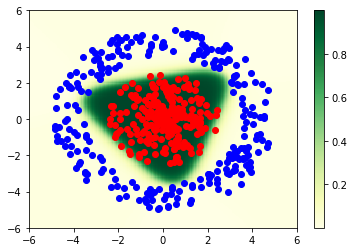

In [7]:
num_points = 200
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)

points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
Y = forward(points, params).reshape(num_points, num_points)
X1, X2 = np.meshgrid(x1s, x2s)

plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))
plt.colorbar()
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 
plt.show()

## 基于torch.autograd的自动微分

`PyTorch`中创建了一个微分引擎`torch.autograd`。它能够对任意计算图的自动地计算微分。

对于一个简单的一层神经网络，假设输入为$x$, 参数为$w$和$b$, 和一些损失函数。在`PyTorch`中可以定义为如下形式：

In [8]:
import torch

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

在上述网络中，$w$和$b$是参数，我们需要去优化的参数。因此，我们需要去计算其梯度信息，所以需要设置`requires_grad=True`。

我们使用`tensor`去构造计算图的时候，实际上就是在构造一个函数类(`class Function`), 这个类知道如何去计算`forward`函数和在`backward propagation`的时候，如何去计算偏微分。反向传播函数存储在`grad_fn`中。

- [https://pytorch.org/docs/stable/autograd.html#function](https://pytorch.org/docs/stable/autograd.html#function)

In [9]:
print("Gradient function for z =", z.grad_fn)
print("Gradient function for loss =", loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x1218b7d90>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward object at 0x1218b78b0>


可以看到对于$z$来说，它的梯度函数其实是一个加法类的。

### 计算梯度

通过调用`backward`方法，我们可以得到梯度。

In [10]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0771, 0.3245, 0.0384],
        [0.0771, 0.3245, 0.0384],
        [0.0771, 0.3245, 0.0384],
        [0.0771, 0.3245, 0.0384],
        [0.0771, 0.3245, 0.0384]])
tensor([0.0771, 0.3245, 0.0384])


这里我们只能得到计算图中`required_grad=True`的这些节点的梯度信息。对于计算图中的其它节点，梯度信息将不能获得。

并且，`PyTorch`中用的是动态图，所以`backward`方法调用一次之后，计算图将会被释放。如果我们需要对其做多次`backward`的话，需要设置`requires_grad=True`。

### 去掉梯度跟踪

当设置了`requires_grad=True`的时候，会自动跟踪一些梯度信息，会将进行反向传播过程中需要的量给存储下来。但是在做推理的时候，我们是不需要去存储这些中间变量的。可以采用`torch.no_grad()`方法，或者`detach()`方法。

In [11]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


In [12]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


上述这些做法在微调模型的时候也是可以用得到的。

- [https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

### Tensor求导，Jacobian Products

通常`loss`是一个标量，但是如果是一个向量的话，那么求导就需要用到`Jacobian Products`。

- [https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

用`PyTorch`演示的话，效果如下:

In [13]:
inp = torch.eye(5, requires_grad=True)
out = (inp + 1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print("First call\n", inp.grad)

First call
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


In [14]:
out.backward(torch.ones_like(inp), retain_graph=True)
print("Second call\n", inp.grad)

Second call
 tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])


In [15]:
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print("Call after zeroing gradients\n", inp.grad)

Call after zeroing gradients
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


在之前调用`backward`的时候我们并没有传入参数，其实是相当于调用`backward(torch.tensor(1.0))`。

## torch.autograd.functional.jacobian

- [https://pytorch.org/docs/stable/generated/torch.autograd.functional.jacobian.html#torch.autograd.functional.jacobian](https://pytorch.org/docs/stable/generated/torch.autograd.functional.jacobian.html#torch.autograd.functional.jacobian)

计算给定的一个函数的`jacobian`函数。

$$
J=\left(\begin{array}{ccc}
\frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}} \\
\vdots & \ddots & \vdots \\
\frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
\end{array}\right)
$$


`torch`中其函数原型为:

```python
torch.autograd.functional.jacobian(func, inputs, create_graph=False, strict=False, vectorize=False)
```

第一个参数`func`是函数，`inputs`是给定的输入x。

In [16]:
def func(x):
    return x.exp()
def func1(x):
    return x * x
x = torch.randn(2, 3)
x

tensor([[-0.1204,  0.4620, -0.1774],
        [-0.3638, -0.6170, -0.4248]])

In [17]:
func(x)

tensor([[0.8866, 1.5872, 0.8374],
        [0.6950, 0.5395, 0.6539]])

In [18]:
from torch.autograd.functional import jacobian
jacobian(func, x)

tensor([[[[0.8866, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 1.5872, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.8374],
          [0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000],
          [0.6950, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5395, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.6539]]]])

In [19]:
x

tensor([[-0.1204,  0.4620, -0.1774],
        [-0.3638, -0.6170, -0.4248]])

In [20]:
jacobian(func1, x)

tensor([[[[-0.2408,  0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000]],

         [[-0.0000,  0.9240, -0.0000],
          [-0.0000, -0.0000, -0.0000]],

         [[-0.0000,  0.0000, -0.3549],
          [-0.0000, -0.0000, -0.0000]]],


        [[[-0.0000,  0.0000, -0.0000],
          [-0.7277, -0.0000, -0.0000]],

         [[-0.0000,  0.0000, -0.0000],
          [-0.0000, -1.2341, -0.0000]],

         [[-0.0000,  0.0000, -0.0000],
          [-0.0000, -0.0000, -0.8497]]]])

可以看到其结果是每个$y$对每个$x$的偏微分的结果。

## hook


### 添加到Tensor上的hook

首先我们创建两个`tensor`，`a`和`b`，`a`的值为`2.0`，`b`的值为`3.0`。

In [21]:
import torch
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)

c = a * b
print(c.grad_fn)

当我们将a和b相乘的时候，也在构建后向图。a和b是有一个属性data来存储数据，但是c会有grad_fn属性，因为a和b中有一个，或者两个的requires_grad=True，此时就会创建后向图。

In [22]:
c.backward()

调用c.backward()时，就会将梯度传递给所构建的后向图中grad_fn指向的节点。

如果想要跟踪，或者修改这些梯度值的话，我们可以采用hook机制

In [23]:
def c_hook(grad):
    print(grad)
    return grad + 2
c.register_hook(c_hook)
c.register_hook(lambda grad : print(grad))
c.retain_grad()

### 添加到Module上的hook

https://www.bilibili.com/video/BV1MV411t7td/?spm_id_from=333.788.recommend_more_video.2

https://www.bilibili.com/video/BV1by4y1B7LD/?spm_id_from=333.788.recommend_more_video.-1

## Numpy实现框架

1. https://zhuanlan.zhihu.com/p/351961835
2. https://zhuanlan.zhihu.com/p/352130729